<a href="https://colab.research.google.com/github/AdarshanandIITBHU/Batch_Reactor_project/blob/main/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting REVERSIBLE reaction simulation to generate dataset...
Generated data for 18 unique conditions.
Dataset successfully saved as 'reversible_reactor_dataset.csv'


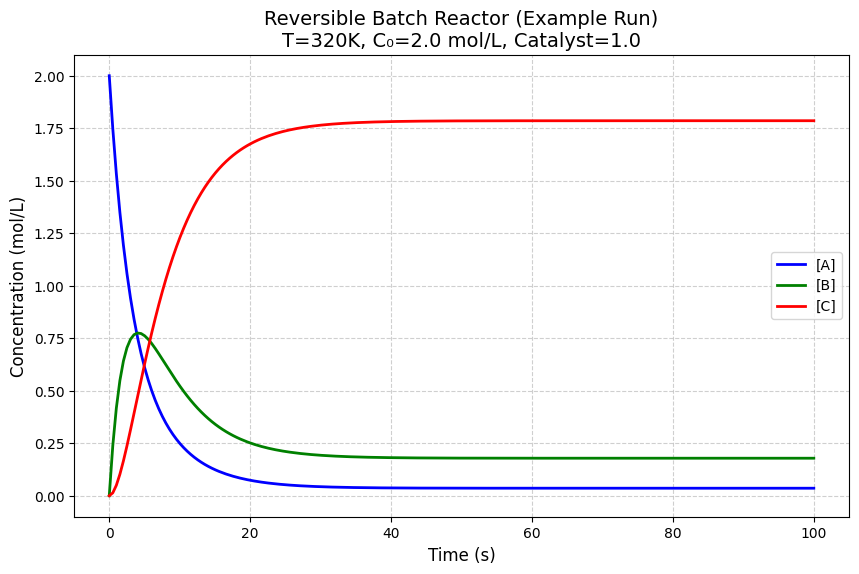

In [1]:
# Batch Reactor Simulation: A <=> B <=> C (Reversible)
# This script simulates a CONSECUTIVE and REVERSIBLE reaction in a batch reactor.

import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------------------------------
# 1. Define Reactor ODEs (The Rules for the Reversible Reaction)
# -----------------------------------------------------------------
# CHANGED: The function now takes 4 rate constants
def reversible_batch_reactor(concentrations, t, k1, k_minus_1, k2, k_minus_2):
    """
    Defines the ODEs for the reversible A <=> B <=> C reaction.
    """
    A, B, C = concentrations

    # CHANGED: Equations now include backward reaction terms
    dAdt = -k1 * A + k_minus_1 * B
    dBdt = k1 * A - k_minus_1 * B - k2 * B + k_minus_2 * C
    dCdt = k2 * B - k_minus_2 * C

    return [dAdt, dBdt, dCdt]

# -----------------------------------------
# 2. Set Simulation Parameters (The Inputs)
# -----------------------------------------
temperatures = [300, 310, 320]
C0_list = [1.0, 1.5, 2.0]
catalyst_levels = [0.5, 1.0]

k_base = 0.1
time = np.linspace(0, 100, 200) # Increased time to see equilibrium

print("Starting REVERSIBLE reaction simulation to generate dataset...")

# ------------------------------------------
# 3. Generate the Dataset (The Experiment)
# ------------------------------------------
dataset = []

for T in temperatures:
    for C0 in C0_list:
        for cat in catalyst_levels:

            # --- Calculate rate constants for this run ---
            # Forward rates
            k1 = k_base * cat * np.exp(0.05 * (T - 300))
            k2 = k_base * 0.8 * cat * np.exp(0.05 * (T - 300))

            # CHANGED: Define backward rate constants (e.g., as a fraction of forward rates)
            k_minus_1 = k1 * 0.2  # 20% of the forward rate
            k_minus_2 = k2 * 0.1  # 10% of the forward rate

            initial_concentrations = [C0, 0, 0]

            # --- Solve the ODEs using the new function and parameters ---
            # CHANGED: Call the new reactor function and pass all 4 rate constants
            concentration_over_time = odeint(
                reversible_batch_reactor,
                initial_concentrations,
                time,
                args=(k1, k_minus_1, k2, k_minus_2)
            )

            # --- Store the results in our dataset ---
            for i, t_val in enumerate(time):
                row = [
                    T, C0, cat, t_val,
                    concentration_over_time[i, 0], # A
                    concentration_over_time[i, 1], # B
                    concentration_over_time[i, 2]  # C
                ]
                dataset.append(row)

print(f"Generated data for {len(temperatures) * len(C0_list) * len(catalyst_levels)} unique conditions.")

# --------------------------------------------
# 4. Format and Save Data (The Report)
# --------------------------------------------
column_names = ['Temperature', 'C0', 'Catalyst', 'Time', 'A', 'B', 'C']
df = pd.DataFrame(dataset, columns=column_names)

output_filename = 'reversible_reactor_dataset.csv'
df.to_csv(output_filename, index=False)

print(f"Dataset successfully saved as '{output_filename}'")

# ----------------------------------------------------
# 5. Example Plot (Visual Check)
# ----------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(time, concentration_over_time[:, 0], label='[A]', color='blue', linewidth=2)
plt.plot(time, concentration_over_time[:, 1], label='[B]', color='green', linewidth=2)
plt.plot(time, concentration_over_time[:, 2], label='[C]', color='red', linewidth=2)

plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Concentration (mol/L)', fontsize=12)
plt.title(f'Reversible Batch Reactor (Example Run)\nT={T}K, C₀={C0} mol/L, Catalyst={cat}', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()